In [1]:
# Personal 
from data.TrajectorySet import TrajectorySet
from data.Sampler import Sampler 
from data.DatasetCL import DatasetCL 
from models.cl_model import mlpCL
from trainer.cl_trainer import train_cl
from utils.visualizations import visualize_embeddings

# Misc
import minari 
import os

# Torch 
import torch 

# PyTorch Lightning 
import pytorch_lightning
from pytorch_lightning.loggers import WandbLogger

In [3]:
MINARI_DATASET = minari.load_dataset("D4RL/pointmaze/large-v2")
PROJECT_ROOT = os.getcwd() 
CHECKPOINT_PATH = PROJECT_ROOT + "/saved_models"

PROJECT_NAME = "Contrastive Learning RL"
RUN_NAME = "real-run-gaussian"

CONFIG = {
        "distribution": "g",
        "batch_size": 512 * 1000,
        "k": 2,
        "lr": 5e-4,
        "weight_decay": 1e-4, 
        "temperature": 0.1,
        "max_epochs": 1000,
        "filename": "best_model_gaussian",
        "device": "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
    }

In [4]:
wandb_logger = WandbLogger(
        project=PROJECT_NAME, 
        name=RUN_NAME, 
        save_dir = PROJECT_ROOT, 
        log_model=True,
        config = CONFIG) 

dist = CONFIG["distribution"]
batch_size = CONFIG["batch_size"]
k = CONFIG["k"]
lr = CONFIG["lr"]
weight_decay = CONFIG["weight_decay"]
temperature = CONFIG["temperature"]
max_epochs = CONFIG["max_epochs"]
device = CONFIG["device"]

T = TrajectorySet(dataset=MINARI_DATASET)
S = Sampler(T, dist=dist)

train_dataset = DatasetCL(S, batch_size=batch_size, k=k)
val_dataset = DatasetCL(S, batch_size=batch_size, k=k)

In [5]:
batch_size

512000

In [6]:
mini_batch_size = batch_size // max_epochs
print("Mini batch size:", mini_batch_size)

model = train_cl(cl_model=mlpCL, 
                train_ds=train_dataset, 
                val_ds=val_dataset, 
                batch_size=mini_batch_size,
                logger=wandb_logger, 
                checkpoint_path=CHECKPOINT_PATH,
                max_epochs=max_epochs,
                filename=CONFIG["filename"],  
                device = device, 
                lr=lr, 
                temperature=temperature, 
                weight_decay = weight_decay)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs
Seed set to 10


Mini batch size: 512


/Users/ray/Documents/Research Assistancy UofA 2025/Reproduce CL/contrastive-learning-RL/CL_RL/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: ray-s (ray-s-university-of-alberta) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



  | Name | Type       | Params | Mode 
--------------------------------------------
0 | mlp  | Sequential | 44.5 K | train
--------------------------------------------
44.5 K    Trainable params
0         Non-trainable params
44.5 K    Total params
0.178     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/ray/Documents/Research Assistancy UofA 2025/Reproduce CL/contrastive-learning-RL/CL_RL/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/ray/Documents/Research Assistancy UofA 2025/Reproduce CL/contrastive-learning-RL/CL_RL/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 44:  79%|███████▉  | 791/1000 [00:16<00:04, 48.26it/s, v_num=3s74, train/nll_loss_step=2.730, train/top1_step=0.354, train/top5_step=0.647, val/nll_loss=2.620, val/top1=0.367, val/top5=0.668, train/nll_loss_epoch=2.610, train/top1_epoch=0.369, train/top5_epoch=0.671] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

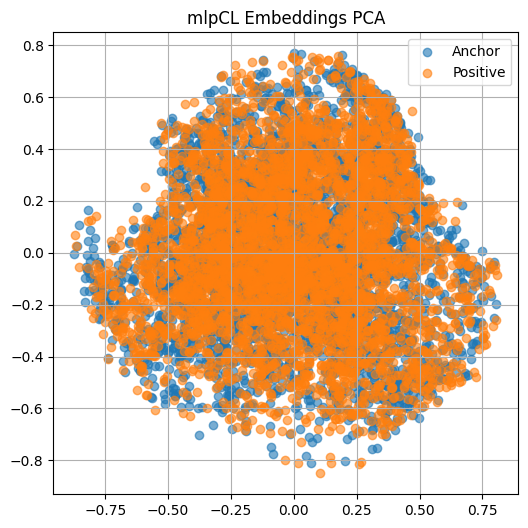

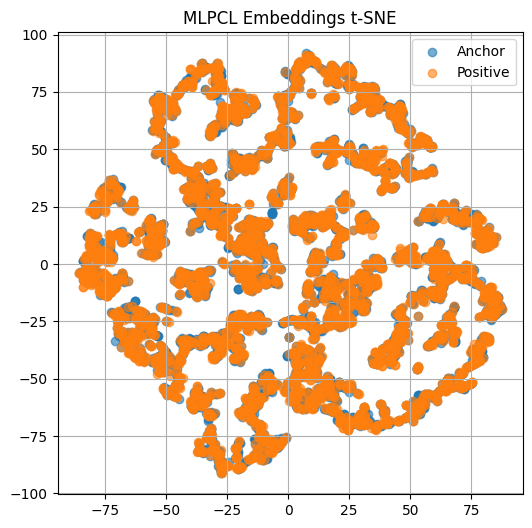

In [9]:
model.eval() 
val_loader = torch.utils.data.DataLoader(dataset= val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
z = model.get_embeddings(val_loader)
visualize_embeddings(z, method="pca", title="mlpCL Embeddings PCA")
visualize_embeddings(z, method="tsne", title="MLPCL Embeddings t-SNE")